# EMG Signal Processing Pipeline

This notebook demonstrates the step-by-step processing pipeline for EMG signals, mirroring the real-time firmware implementation.

**Pipeline Steps:**
1. **Raw Data Loading**: Ingesting raw sensor data.
2. **Filtering**: Bandpass (20-450Hz) and Notch (50Hz) to remove noise.
3. **Rectification**: Full-wave rectification to estimate signal power.
4. **Feature Extraction**: Computing Mean Absolute Value (MAV) and Waveform Length (WL).

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Add src to path for imports
sys.path.insert(0, '../')

from lib.data_loader import Enabl3sDataLoader
from lib.preprocess import EMGPreprocessor

# Setup plotting
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (15, 6)

## 1. Data Loading

We load a single circuit from patient `AB156` to visualize the signals.

In [2]:
DATA_ROOT = "../../data"
SUBJECT_ID = "AB156"
CHANNELS = ['TA', 'MG', 'Ankle_Angle', 'Knee_Angle', 'Mode']

# Initialize Loader
fs = 500
loader = Enabl3sDataLoader(DATA_ROOT, SUBJECT_ID, target_fs=fs)

# Load specific circuit
circuit_num = len(os.listdir(os.path.join(DATA_ROOT, SUBJECT_ID, 'Raw')))
circuit_range = range(1, circuit_num + 1)
df_raw = loader.load_dataset_batch(circuit_range, CHANNELS)

df_raw.head()

10:48:41 - INFO - Starting batch load: Circuits 1 to 50...
10:48:42 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). Swing Ratio: 57.07%
10:48:42 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). Swing Ratio: 33.32%
10:48:43 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). Swing Ratio: 33.05%
10:48:43 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). Swing Ratio: 40.71%
10:48:44 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). Swing Ratio: 26.70%
10:48:44 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). Swing Ratio: 30.75%
10:48:45 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). Swing Ratio: 33.10%
10:48:45 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). Swing Ratio: 30.31%
10:48:46 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). Swing Ratio: 52.06%
10:48:46 - INFO - Label

,TA,MG,Ankle_Angle,Knee_Angle,Mode,Ankle_Norm,Circuit_ID,Label_Phase
0,-0.102846,-0.074235,2.116808,3.090944,0.0,0.438050,1.0,0.0
1,-0.079728,-0.053254,2.116808,3.090944,0.0,0.438050,1.0,0.0
2,-0.067216,-0.043183,2.115587,3.092164,0.0,0.438011,1.0,0.0
3,-0.062409,-0.037766,2.114366,3.093385,0.0,0.437973,1.0,0.0
4,-0.092851,-0.056077,2.114366,3.092164,0.0,0.437973,1.0,0.0


In [3]:
raw_data = df_raw.values
time_axis = np.arange(len(df_raw)) / fs

view_window = slice(10 * fs, 20 * fs)

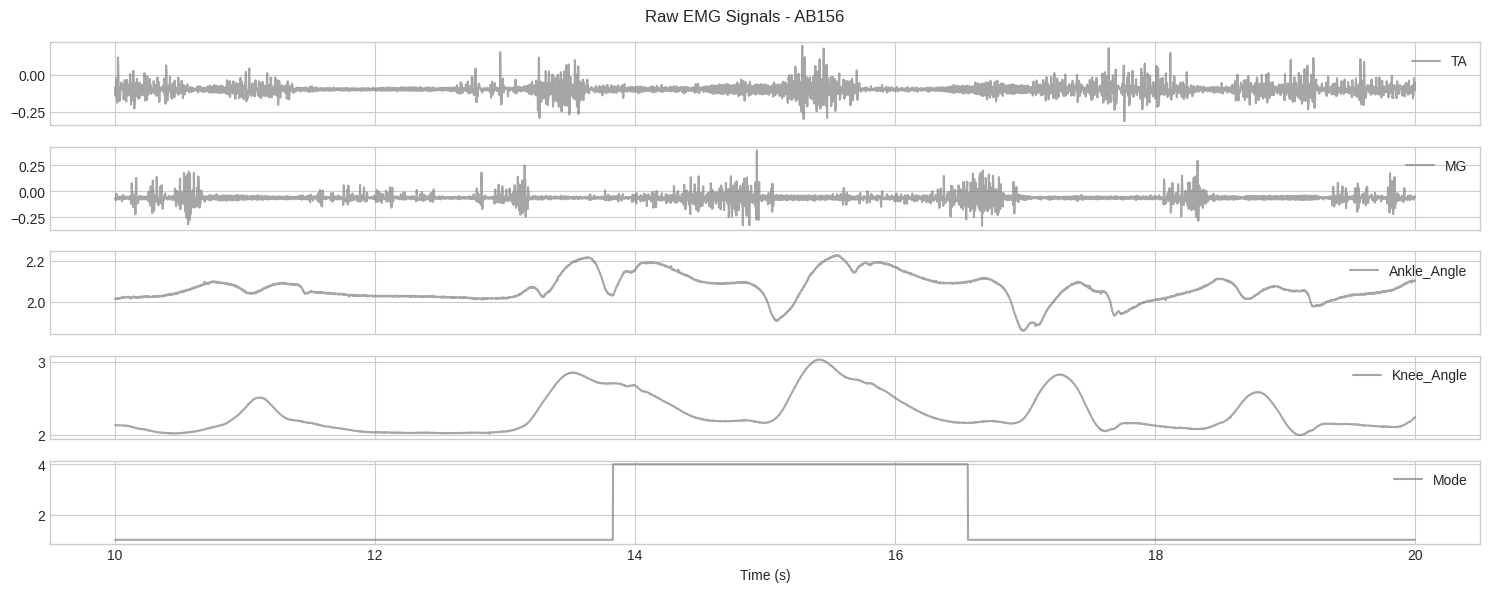

In [4]:
# Plot Raw Signals
fig, axes = plt.subplots(len(CHANNELS), 1, sharex=True)
fig.suptitle(f"Raw EMG Signals - {SUBJECT_ID}")

for i, ch in enumerate(CHANNELS):
    axes[i].plot(time_axis[view_window], raw_data[view_window, i], label=f'{ch}', color='gray', alpha=0.7)
    axes[i].legend(loc='upper right')

axes[-1].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()

## 2. Filtering

We apply two filters to clean the signal:
1. **Bandpass Filter (20-450 Hz)**: Removes low-frequency motion artifacts and high-frequency noise outside the EMG spectrum.
2. **Notch Filter (50 Hz)**: Removes power line interference.

> **Note**: The filters are *causal* (using `lfilter`/`sosfilt` instead of `filtfilt`) to simulate real-time processing delays.

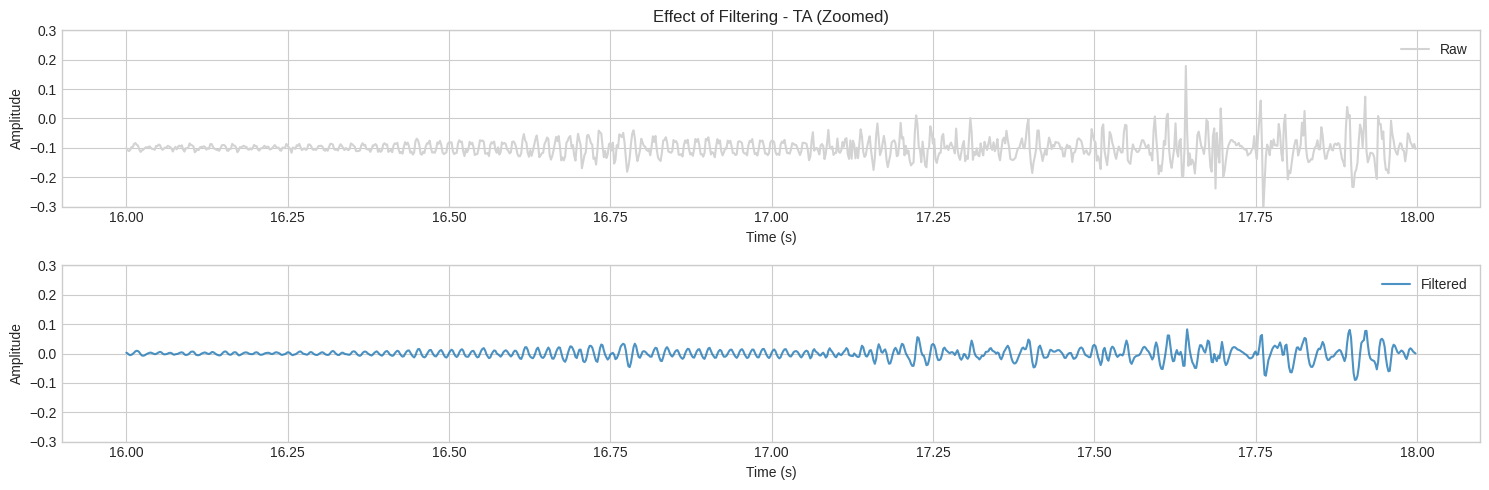

In [5]:
preprocessor = EMGPreprocessor(fs=1000.0)

# Apply Filter
filtered_data = preprocessor.apply_filter(raw_data)

# Visualize Filter Effect (Zoomed in)
# Choosing a window where there might be activity to see signal preservation, or rest to see noise removal
zoom_slice = slice(8000, 9000)

fig, ax = plt.subplots(2, 1, figsize=(15, 5))
ax[0].set_title(f"Effect of Filtering - {CHANNELS[0]} (Zoomed)")
ax[0].plot(time_axis[zoom_slice], raw_data[zoom_slice, 0], label='Raw', color='lightgray')
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Amplitude")
ax[0].set_ylim([-0.3, 0.3])
ax[0].legend()

ax[1].plot(time_axis[zoom_slice], filtered_data[zoom_slice, 0], label='Filtered', color='tab:blue', alpha=0.8)
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Amplitude")
ax[1].set_ylim([-0.3, 0.3])
ax[1].legend()

plt.tight_layout()
plt.show()

## 3. Rectification

EMG signals are oscillatory with a zero mean. To estimate the muscle activation intensity, we perform full-wave rectification (absolute value).

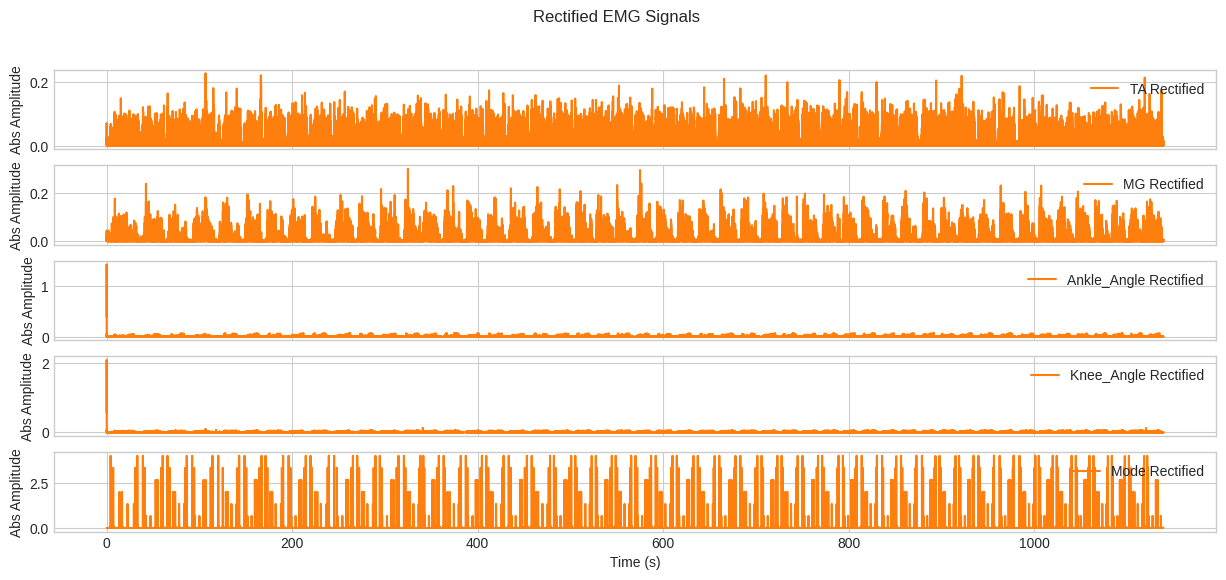

In [6]:
rectified_data = preprocessor.rectify(filtered_data)

# Plot Rectified Signal
fig, axes = plt.subplots(len(CHANNELS), 1, sharex=True)
fig.suptitle("Rectified EMG Signals")

for i, ch in enumerate(CHANNELS):
    axes[i].plot(time_axis, rectified_data[:, i], label=f'{ch} Rectified', color='tab:orange')
    axes[i].set_ylabel("Abs Amplitude")
    axes[i].legend(loc='upper right')

axes[-1].set_xlabel("Time (s)")
plt.show()